In [1]:
# 출처 : https://medium.com/@yevhenii.chulinda/calculate-retention-rate-using-cohort-analysis-53a8a81fd64c

In [9]:
# local only
import os
# os.environ["NLS_LANG"] = ".AL32UTF8"      #encodring이 UTF-8 인 경우

from os import listdir
import cx_Oracle as oci

from konlpy.tag import Okt
from tqdm import tqdm
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from operator import attrgetter

# 그래프
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:/windows/Fonts/malgun.ttf'                           # 폰트:맑은고딕
font_name = fm.FontProperties(fname=path, size=24).get_name()  
plt.rc('font', family=font_name)

In [2]:
###############
# 1.데이터 불러오기
#####

# DB접속 : 접속정보 읽기
con_text = open("C:/Users/MAEIL/conn_CRM.txt", 'r', encoding='utf8')
con_text = con_text.read()
conn = oci.connect(con_text, encoding='UTF-8', nencoding='UTF-8')

In [3]:
# query run
query = '''
        select reg_dtm, unfy_mmb_no, lgn_coopco_cd
        from mmbship.tm_lgn_hist
        where reg_dtm between ADD_MONTHS( TRUNC(sysdate,'MM'), -3) and ADD_MONTHS( LAST_DAY(sysdate), -1 )
        '''
event = pd.read_sql(query, con = conn )

In [4]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1238998 entries, 0 to 1238997
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   REG_DTM        1238998 non-null  datetime64[ns]
 1   UNFY_MMB_NO    1238998 non-null  int64         
 2   LGN_COOPCO_CD  1238998 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 28.4+ MB


In [5]:
events = event.drop_duplicates()
events['month'] = events['REG_DTM'].dt.to_period('M')
events['cohort'] = events.groupby('UNFY_MMB_NO')['REG_DTM'].transform('min').dt.to_period('M')

In [10]:
cohort_df = events.groupby(['cohort', 'month'], as_index=False).agg(user_count=('UNFY_MMB_NO', 'nunique'))
cohort_df['period_number'] = (cohort_df.month - cohort_df.cohort).apply(attrgetter('n'))

In [11]:
cohort_df

,cohort,month,user_count,period_number
0,2021-12,2021-12,98344,0
1,2021-12,2022-01,49881,1
2,2021-12,2022-02,42638,2
3,2022-01,2022-01,45939,0
4,2022-01,2022-02,14299,1
5,2022-02,2022-02,33562,0


In [12]:
cohort_pivot = cohort_df.pivot_table(index='cohort', columns='period_number', values='user_count')

In [13]:
cohort_pivot

period_number,0,1,2
cohort,,,
2021-12,98344.0,49881.0,42638.0
2022-01,45939.0,14299.0,NaN
2022-02,33562.0,NaN,NaN


In [14]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [15]:
retention_matrix

period_number,0,1,2
cohort,,,
2021-12,1.0,0.507209,0.43356
2022-01,1.0,0.311261,NaN
2022-02,1.0,NaN,NaN


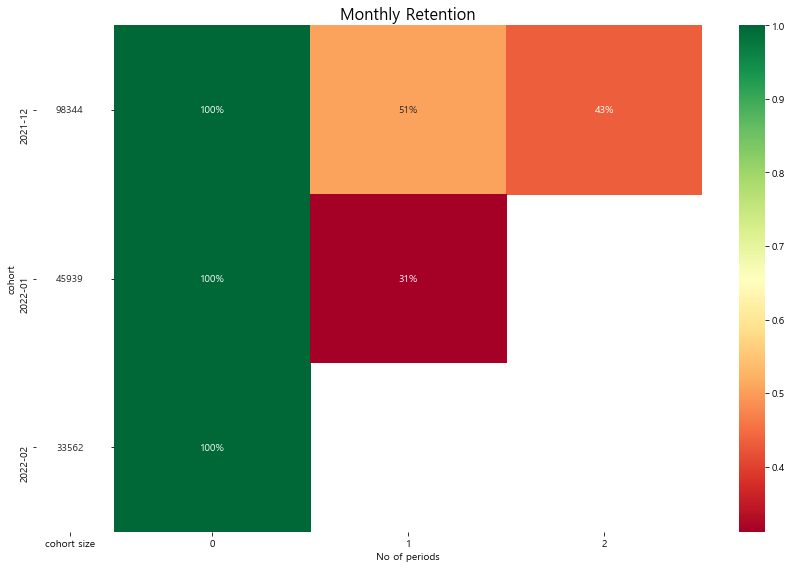

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True,  gridspec_kw={'width_ratios': [1, 11]})
sns.heatmap(retention_matrix,mask=retention_matrix.isnull(), annot=True, fmt='.0%', cmap='RdYlGn', ax=ax[1])
ax[1].set_title('Monthly Retention', fontsize=16)
ax[1].set(xlabel='# of periods', ylabel='')

cohort_size_df = pd.DataFrame(cohort_size) .rename(columns={0: 'cohort size'})
white_cmap = mpl.colors.ListedColormap(['white'])
sns.heatmap(cohort_size_df, annot=True, cbar=False, fmt='g', cmap=white_cmap, ax=ax[0])
fig.tight_layout()
plt.show()